In [3]:
# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model, Sequential
from keras.layers import Input, LSTM, Dense, RepeatVector, \
                         TimeDistributed, Activation, GRU, Dropout, \
                         Bidirectional
from keras.callbacks import EarlyStopping
import pickle

!rm helpers.py
!wget https://github.com/cmantas/keras_seq2seq/raw/master/helpers.py 2>&1 /dev/null
from helpers import *


Using TensorFlow backend.


--2018-10-31 16:18:07--  https://github.com/cmantas/keras_seq2seq/raw/master/helpers.py
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmantas/keras_seq2seq/master/helpers.py [following]
--2018-10-31 16:18:08--  https://raw.githubusercontent.com/cmantas/keras_seq2seq/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10541 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.29K  --.-KB/s    in 0s      

2018-10-31 16:18:08 (91.5 MB/s) - ‘helpers.py’ saved [10541/10541]

/dev/null: Scheme missing.
FINISHED --2018-10-31 16:1

In [4]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Sentences from the [tatoeba dataset](https://tatoeba.org/eng/downloads)

In [0]:
epochs = 50  # Number of epochs to train for.
train_size =200000 # Number of samples to train on.
val_size = 2000
# Path to the txt file on disk.
data_path = '/drive/My Drive/ML/sentences.txt'

noise = .05
misspellings_count = 3
batch_size = 1000  # Batch size for training.

optimizer= 'adam'
loss_fn='categorical_crossentropy'
# Hand-pick maximum sequence lengths
max_string_length = 25 # max (allowed) input string length
max_seq_length = 30 # accomodate for the delimiters + spelling correction


In [9]:
all_phrases = load_preprocessed(data_path, max_string_length)
assert len(all_phrases) > train_size + val_size
train_phrases = all_phrases[:train_size]
test_phrases = all_phrases[train_size: train_size + val_size]

print('All phrases in dataset: ', len(all_phrases))
print('Training phrases: ', len(train_phrases))
print('Test phrases: ', len(test_phrases))

print("\n * ".join(['Examples:'] + all_phrases[:10]))

All phrases in dataset:  239820
Training phrases:  200000
Test phrases:  2000
Examples:
 * tom is reading a book now
 * tom is quite strong
 * what did you just do?
 * tom unloaded the car
 * you aren't hurt
 * i had a hard time
 * tom actually likes me
 * i'm loaded
 * i began working
 * how was the interview?


In [10]:
# create doken indices out of all phrases
token_idx = token_index(all_phrases + ['\t', '\n'])
# ^^ \t and \n are our [START] and [END] delimiters. With this trick
# we are adding them to the token index

num_encoder_tokens = len(token_idx)

print('Number of unique tokens:', num_encoder_tokens)

Number of unique tokens: 57


In [0]:
def simple_lstm(output_len, token_count):
    """Generate the model"""
    latent_dim = 1024  # Latent dimensionality of the encoding space.
    initializer = 'he_normal'

    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = LSTM(latent_dim, input_shape=(None, token_count), 
                   kernel_initializer=initializer)

    # For the decoder's input, we repeat the encoded input for each time step
    repeater = RepeatVector(output_len)

    decoder = LSTM(latent_dim, return_sequences=True, kernel_initializer=initializer)

    # For each of step of the output sequence, decide which character should be chosen
    time_dist = TimeDistributed(Dense(token_count, kernel_initializer=initializer))
    activation = Activation('softmax')
    
    model = Sequential([encoder, repeater, decoder, time_dist, activation])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
def deep_lstm(output_len, token_count):
    """Generate the model"""
    latent_dim = 256  # Latent dimensionality of the encoding space.
    initializer = 'he_normal'

    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder_1 = LSTM(latent_dim, input_shape=(None, token_count),
                     return_sequences=True,
                     kernel_initializer=initializer)
    
    dropout1 = Dropout(.05)

    encoder_2 = LSTM(latent_dim, input_shape=(None, token_count),
                 kernel_initializer=initializer)

    # For the decoder's input, we repeat the encoded input for each time step
    repeater = RepeatVector(output_len)

    decoder_1 = LSTM(latent_dim, return_sequences=True, kernel_initializer=initializer)
    dropout2 = Dropout(.05)
    decoder_2 = LSTM(latent_dim, return_sequences=True, kernel_initializer=initializer)

    # For each of step of the output sequence, decide which character should be chosen
    time_dist = TimeDistributed(Dense(token_count, kernel_initializer=initializer))
    activation = Activation('softmax')
    
    model = Sequential([encoder_1, dropout1, encoder_2,
                        repeater, 
                        decoder_1, dropout2, decoder_2, 
                        time_dist, activation])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
  
def simple_lstm_2(output_len, token_count):
  # 50 epoch: loss: 0.0928 - acc: 0.7668 - val_loss: 0.1042 - val_acc: 0.7663
  """Generate the model"""
  latent_dim = 512  # Latent dimensionality of the encoding space.

  # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
  # note: in a situation where your input sequences have a variable length,
  # use input_shape=(None, nb_feature).
  encoder = LSTM(latent_dim, return_sequences=True,
                 input_shape=(output_len, token_count))

  # For the decoder's input, we repeat the encoded input for each time step
  #repeater = RepeatVector(output_len)

  decoder = LSTM(latent_dim, return_sequences=True)

  # For each of step of the output sequence, decide which character should be chosen
  time_dist = TimeDistributed(Dense(token_count,  activation='softmax'))
  #activation = Activation('softmax')

  model = Sequential([encoder, decoder, time_dist])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


def bidrectional_lstm(output_len, token_count):
  """Generate the model"""
  latent_dim = 512  # Latent dimensionality of the encoding space.

  layers = [
      # something like an encoder
      Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=.2, 
                         recurrent_dropout=0.2),
                    input_shape=(output_len, token_count)),
      
      # ~decoder
      LSTM(latent_dim, return_sequences=True, dropout=.2),
      
      # time-distr activation
      TimeDistributed(Dense(token_count)),
      TimeDistributed(Dense(token_count,  activation='softmax')),
  ]

  model = Sequential(layers)

  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  return model

In [0]:
gen_model = bidrectional_lstm

In [0]:
val_misspellings, val_correct = create_misspellings(test_phrases[:2000],
                                            noise, misspellings_count,
                                            max_seq_length)

val_X = vectorize_batch(val_misspellings, token_idx,
                  max_seq_length, dtype=np.bool)
val_Y = vectorize_batch(wrap_with_delims(val_correct), token_idx,
                  max_seq_length, dtype=np.bool)

In [0]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=.005, 
#                                patience=3, verbose=0, mode='auto')

In [0]:
def batcher(phrases, batch_size):
  for i in range(0, len(phrases), batch_size):
    frrom = i
    to = i+batch_size
    yield phrases[frrom:to]

def chunkify(lst,n):
  return [lst[i::n] for i in range(n)]
    
def misspelled_gen(phrases, batch_size, noise, misspellings_count,
                  max_seq_length):
  gen = batcher(phrases, batch_size)
  for batch in gen:
    misspelled, correct = create_misspellings(batch,
                                      noise, misspellings_count,
                                      max_seq_length)
    mis_chunks = chunkify(misspelled, misspellings_count + 1)
    cor_chunks = chunkify(correct, misspellings_count + 1)
    
    yield from zip(mis_chunks, cor_chunks)

In [0]:
def training_gen(phrases, batch_size, noise, misspellings_count,
                  max_seq_length, token_idx):

  while True:
    Random().shuffle(phrases)
    mis_gen = misspelled_gen(phrases, batch_size, noise, misspellings_count,
                             max_seq_length)
    for mis, cor in mis_gen:
      X = vectorize_batch(mis, token_idx,
                          max_seq_length, dtype=np.bool)
      Y = vectorize_batch(wrap_with_delims(cor), token_idx,
                          max_seq_length, dtype=np.bool)
      yield (X, Y)

In [0]:
steps_per_epoch = (len(train_phrases) *(misspellings_count + 1) / batch_size)#30 <-for test

In [0]:
gen = training_gen(train_phrases, batch_size, noise, misspellings_count, 
                   max_seq_length, token_idx)

model = gen_model(max_seq_length, len(token_idx))
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=.005, 
#                                patience=3, verbose=0, mode='auto')

hist = model.fit_generator(gen, validation_data=(val_X, val_Y),
                    steps_per_epoch=steps_per_epoch,
                    verbose=1, max_queue_size=1, epochs=epochs)

Epoch 1/50
  7/800 [..............................] - ETA: 29:33 - loss: 2.8265 - acc: 0.0981

In [67]:
dual_evaluate_batch(val_correct, val_misspellings, model, token_idx, 
                    max_seq_length)

(0.0775, 0.515125)

In [0]:
model.save('/drive/My Drive/ML/n_to_n_bidirectional_dropouts_2xtimedist_latent_dim_512.h5')

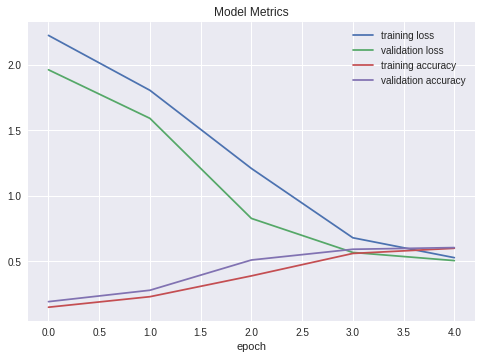

In [15]:
plot_history(hist)

NameError: ignored

In [0]:
corrector = sequential_translator_fn(model, token_idx, max_seq_length)

In [29]:
[(corrector(p), p, corrector(p) == p) for p in train_phrases[:20]]

[('\t                ', 'good to be here', False),
 ('\t                   ', 'i need someone to hold me', False),
 ('\t                  ', 'ann gave me this present', False),
 ('\t                 ', 'tom has a lot of toys', False),
 ('\t                 ', "i'm furious with you", False),
 ('\t                 ', 'it was my first job', False),
 ('\t                  ', "here's a picture of her", False),
 ('\t                 ', 'mary loves australia', False),
 ('\t                 ', 'is he married?', False),
 ('\t                 ', 'this well is very deep', False),
 ('\t                   ', "we'd be foolish to do so", False),
 ('\t                 ', 'come meet everybody', False),
 ('\t                 ', 'catch you later', False),
 ('\t                 ', 'i wrote them a letter', False),
 ('\t                 ', 'it kept me occupied', False),
 ('\t                 ', 'it surprises me', False),
 ('\t                 ', 'no one followed me', False),
 ('\t                 ', "that's

In [25]:
print(evaluate_correct(train_phrases[:1000], corrector))
print(evaluate_correct(train_phrases[-1000:], corrector))
print(evaluate_misspelled(train_phrases[:1000], corrector))
print(evaluate_correct(test_phrases[:1000], corrector))
print(evaluate_misspelled(test_phrases[:1000], corrector))

0.032
0.029
0.398
0.044
0.444


In [0]:
plot_history(model.history)

In [0]:
# find max encoder seq legth
#max_encoder_seq_length = encoder_model.get_layer('encoder_inputs').input_shape[-1]
phrases = ['fire', 'stp', 'comein', 'get ot', 'i cant go','im sorry', 
           'h is busi', 'hes drunk', 'ill be lat', 'hold mi beer', 'pus the buton', 
          'coll me on my phone', 'helo boys and girls']

[corrector(phrase) for phrase in phrases]

In [1]:
!hostname

f248df630aff
